In [6]:
import pandas as pd
import numpy as np
import pickle
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

In [7]:
df = pd.read_csv('combined_with_split_tags.csv')
df

,Tag,Cleaned_Text,Length,Emoticons_count,Emoticons Avg,Unique_Words,TTR,anger,anticipation,disgust,...,interrogative,article,subordination,conjunction.1,preposition.1,count,E_I,N_S,F_T,J_P
0,ENFP,disagree think theory given validity rather be...,1682,0,0.000000,25,0.014863,0.002378,0.003567,0.000595,...,0,1,0,0,0,228,E,N,F,P
1,INTP,selfish generally perform task better person a...,1265,0,0.000000,26,0.020553,0.010277,0.006324,0.010277,...,0,0,0,0,0,177,I,N,T,P
2,INFP,personality system technically separate types...,738,0,0.000000,25,0.033875,0.001355,0.000000,0.004065,...,0,1,0,0,0,129,I,N,F,P
3,INTP,like functions general theyre basically ways p...,1550,0,0.000000,25,0.016129,0.002581,0.006452,0.002581,...,1,0,0,0,0,206,I,N,T,P
4,ENTP,even referring nihilism yeah point dying livin...,767,0,0.000000,25,0.032595,0.011734,0.007823,0.006519,...,0,0,0,0,0,110,E,N,T,P
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12821,ISTP,kinda amusing deal trust relate usually someon...,599,0,0.000000,24,0.040067,0.000000,0.005008,0.001669,...,0,0,0,0,0,88,I,S,T,P
12822,ESFP,social 9 description fit better probably descr...,617,23,0.037277,25,0.040519,0.000000,0.003241,0.003241,...,0,0,0,0,0,89,E,S,F,P
12823,ISFP,believe blood type influence someone personali...,260,0,0.000000,26,0.100000,0.000000,0.003846,0.000000,...,0,0,0,0,0,34,I,S,F,P
12824,INFJ,benevolent creator linkpractical 26 conceptual...,645,2,0.003101,25,0.038760,0.001550,0.007752,0.001550,...,0,0,0,0,0,95,I,N,F,J


In [8]:
df['FT'] = df['Tag'].apply(lambda x: 1 if 'F' in x else 0)
df['FT']

0        1
1        0
2        1
3        0
4        0
        ..
12821    0
12822    1
12823    1
12824    1
12825    1
Name: FT, Length: 12826, dtype: int64

In [17]:
grid_search = pickle.load(open('model_ft.sav', 'rb'))

In [10]:
FT_allfeatures = df.drop(columns = ['Tag', 'FT','E_I',	'N_S',	'F_T',	'J_P'])
FT_y = df['FT']

X_train, X_test, y_train, y_test = train_test_split(FT_allfeatures, FT_y, test_size=0.2, random_state=1)
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

In [11]:
X_train_cleanedtext = X_train['Cleaned_Text']
X_train_features = X_train.drop(columns = ['Cleaned_Text'])
X_train_features = X_train_features.reset_index(drop = True)

X_test_cleanedtext = X_test['Cleaned_Text']
X_test_features = X_test.drop(columns = ['Cleaned_Text'])
X_test_features = X_test_features.reset_index(drop = True)

In [12]:
# Word Representation

vect = CountVectorizer(max_features = 5000)
X_train_dtm = vect.fit_transform(X_train_cleanedtext)
X_test_dtm = vect.transform(X_test_cleanedtext)

In [13]:
X_train_dtm_df = pd.DataFrame(X_train_dtm.toarray(), columns = vect.get_feature_names())
X_test_dtm_df = pd.DataFrame(X_test_dtm.toarray(), columns = vect.get_feature_names())

X_train_allfeatures = pd.concat([X_train_dtm_df, X_train_features], axis=1)
X_test_allfeatures = pd.concat([X_test_dtm_df, X_test_features], axis=1)

In [63]:
# Predicting on the transformed data
grid_predictions = grid_search.predict(X_test_allfeatures)

# calculate accuracy of class predictions
from sklearn import metrics
metrics.accuracy_score(y_test, grid_predictions )

0.6769290724863601

In [19]:
grid_search.best_params_

{'bootstrap': True,
 'class_weight': 'balanced',
 'max_depth': 80,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 300}

In [65]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(bootstrap = True, class_weight = 'balanced',
                                   max_depth= 80,min_samples_leaf =3, min_samples_split= 8,n_estimators =300)
                                   
forestOpt = forest.fit(X_train_allfeatures,y_train)
y_pred = forestOpt.predict(X_test_allfeatures)

In [69]:
# Predicting on the transformed data
forest_predictions = forestOpt.predict(X_test_allfeatures)

# calculate accuracy of class predictions
from sklearn import metrics
metrics.accuracy_score(y_test,forest_predictions )

0.6858924395946999

In [99]:
scores = forestOpt.feature_importances_
indices = np.argsort(forestOpt.feature_importances_)[::-1]
top20_indices = indices[0:20]

print("Feature ranking:")

top20_features = []
top20_score = []

for i in top20_indices:   
    print(X_train_allfeatures.columns[i], scores[i])
    top20_features.append(X_train_allfeatures.columns[i])
    top20_score.append(scores[i])


Feature ranking:
feel 0.01173012401830655
joy 0.01122556565182923
Afinn Score 0.01117286882717217
Polarity 0.009843188761961337
love 0.008582173702483977
Subjectivity 0.0079729505189713
Emoticons Avg 0.006403124068475789
sadness 0.005933991683432187
surprise 0.005569354174115057
positive 0.005540991746341506
Emoticons_count 0.005505498719262051
count 0.005203572653034453
Length 0.0051173196334435974
TTR 0.005034185816639561
trust 0.004962340894775154
anticipation 0.004962318778395266
fear 0.00480917069316271
anger 0.004588232786587863
negative 0.00458188126542785
DaleChallIndex 0.004530309209050763


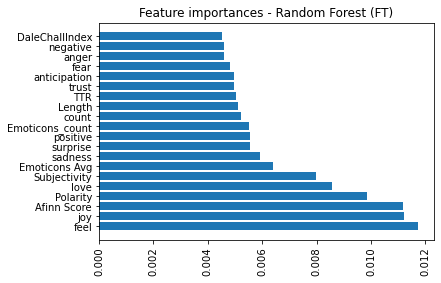

In [101]:
import matplotlib.pyplot as plt
plt.figure()
plt.title("Feature importances - Random Forest (FT)")
plt.barh(top20_features, top20_score, height=0.8, align='center')
plt.xticks(rotation='vertical')
plt.show()